In [1]:
%pip install scikit-learn spacy numpy pandas tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import spacy
import spacy.cli
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold

SVD_EMBEDDING_DIM = 1
EMBEDDING_MAP = None

K = 5
KF = KFold(n_splits=K, shuffle=True)

spacy.cli.download("en_core_web_md")
nlp = spacy.load("en_core_web_md")


def embed_genres(data: pd.DataFrame) -> dict[str, np.ndarray]:
    unique_genres = data["track_genre"].dropna().unique()
    tokenized = pd.Series(unique_genres).str.lower().str.split().to_list()

    def avg_vector(tokens: list[str]) -> np.ndarray:
        vectors = [nlp.vocab[t].vector for t in tokens if nlp.vocab[t].has_vector]

        return (
            np.mean(vectors, axis=0) if vectors else np.zeros(nlp.vocab.vectors_length)
        )

    vectors = np.vstack([avg_vector(tokens) for tokens in tokenized])
    svd_vectors = TruncatedSVD(n_components=SVD_EMBEDDING_DIM).fit_transform(vectors)

    return {genre: svd_vectors[i] for i, genre in enumerate(unique_genres)}


def prepare_X(data: pd.DataFrame) -> pd.DataFrame:
    global EMBEDDING_MAP  # noqa: PLW0603

    if EMBEDDING_MAP is None:
        EMBEDDING_MAP = embed_genres(data)

    col_names = [f"genre_svd_{i}" for i in range(SVD_EMBEDDING_DIM)]
    vec_df = pd.DataFrame(
        data["track_genre"].map(EMBEDDING_MAP).tolist(),
        columns=col_names,
        index=data.index,
    )

    return pd.concat([data.drop(columns=["track_genre"]), vec_df], axis=1)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
# Load data
data = pd.read_csv("data/train_data.csv").sort_values("popularity", ascending=False)

# Prepare X and Y
X, Y = prepare_X(data).drop("popularity", axis=1), data["popularity"]

5it [00:55, 11.06s/it]


Test R^2 score: 0.6022722999420584


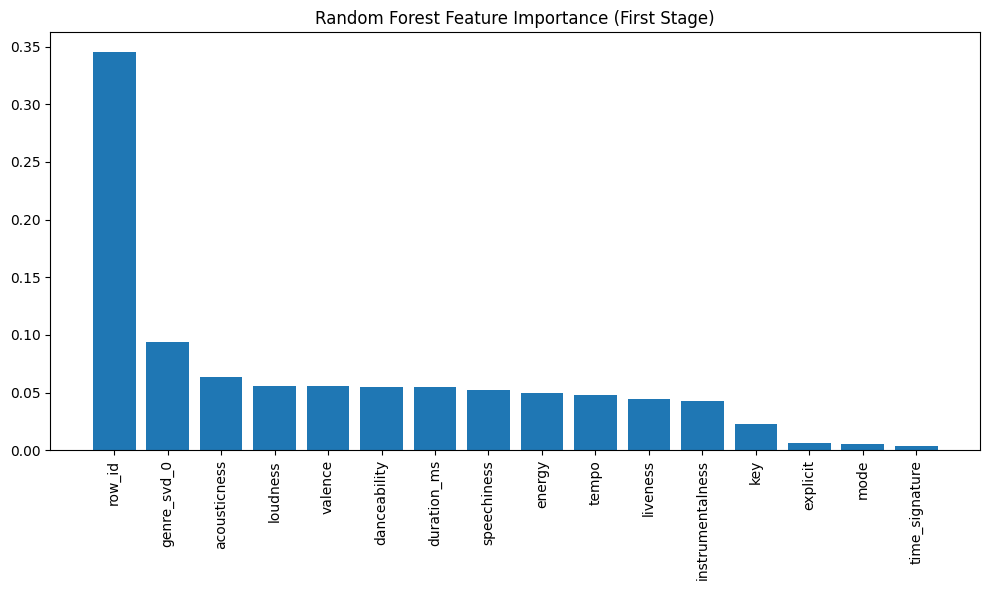

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, train_test_split
from tqdm import tqdm

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

models = []

for train_idx, _ in tqdm(KF.split(X_train)):
    X_tr, Y_tr = X_train.iloc[train_idx], Y_train.iloc[train_idx]

    Y_tr -= sum([model.predict(X_tr) for model in models])

    models.append(RandomForestRegressor(n_estimators=100, n_jobs=-1).fit(X_tr, Y_tr))

y_test_pred = sum([model.predict(X_test) for model in models])
print("Test R^2 score:", r2_score(Y_test, y_test_pred))

indices = models[0].feature_importances_.argsort()[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), models[0].feature_importances_[indices])
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.title("Random Forest Feature Importance (First Stage)")
plt.tight_layout()
plt.show()


In [5]:
# Retrain full model
models = []

for train_idx, _ in tqdm(KF.split(X)):
    X_tr, Y_tr = X.iloc[train_idx], Y.iloc[train_idx]

    Y_tr -= sum([model.predict(X_tr) for model in models])

    models.append(RandomForestRegressor(n_estimators=100, n_jobs=-1).fit(X_tr, Y_tr))

5it [01:12, 14.49s/it]


In [6]:
import datetime

# Load test data
data_test = pd.read_csv("data/test_data.csv")

# Prepare test data
X_test = prepare_X(data_test)

# Make predictions
Y_pred = sum([model.predict(X_test) for model in models])

# Save predictions, index is row_id
Y_pred_df = pd.DataFrame(Y_pred, columns=["popularity"])
Y_pred_df.index = data_test["row_id"]

# Save CSV
filename = "pred/pred_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + ".csv"
Y_pred_df.to_csv(filename, index_label="row_id")